In [2]:
!nvidia-smi

Wed Nov  1 04:36:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-11-01 04:36:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-01 04:36:38 (48.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training
data

In [5]:

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-11-01 04:36:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.207, 209.85.146.207, 209.85.147.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   162MB/s    in 14s     

2023-11-01 04:37:03 (112 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images/classes are there?
walk_through_dir("/content/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/caesar_salad'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '/

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False
)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layers
* Build a headless (no top layers) Functional EficcientNetB0 backboned-model
* Compile our model
* Feature extract 5 full passes

In [8]:
#  Create model checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True
    )

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential


# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2),
     preprocessing.RandomZoom(0.2),
], name="data_augmentation")




In [10]:
# set up base model

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture
inputs= layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Put the base model in inference mode
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(test_data.class_names), activation='softmax', name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [12]:
# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [13]:
# Fit model

history_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=3,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # Valide only on 15 off test data
    callbacks=[checkpoint_callback]
    )

Epoch 1/3
237/237 [==============================] - 117s 426ms/step - loss: 0.0872 - accuracy: 0.1465 - val_loss: 0.0498 - val_accuracy: 0.2876
Epoch 2/3
237/237 [==============================] - 77s 321ms/step - loss: 0.0463 - accuracy: 0.3979 - val_loss: 0.0422 - val_accuracy: 0.4153
Epoch 3/3
237/237 [==============================] - 68s 283ms/step - loss: 0.0388 - accuracy: 0.4974 - val_loss: 0.0384 - val_accuracy: 0.4738


In [14]:
# Evaluate on the wole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 59s 74ms/step - loss: 0.0379 - accuracy: 0.5307


[0.03787759691476822, 0.5307326912879944]

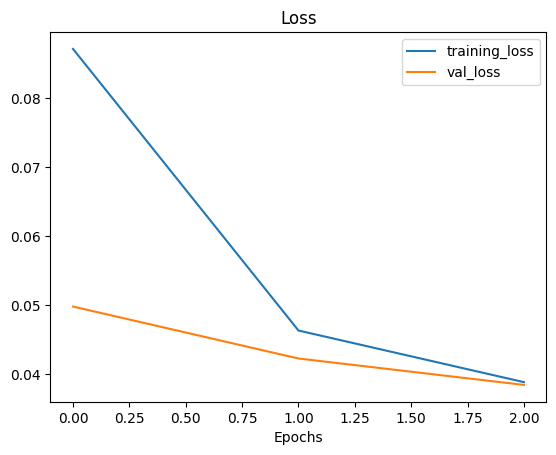

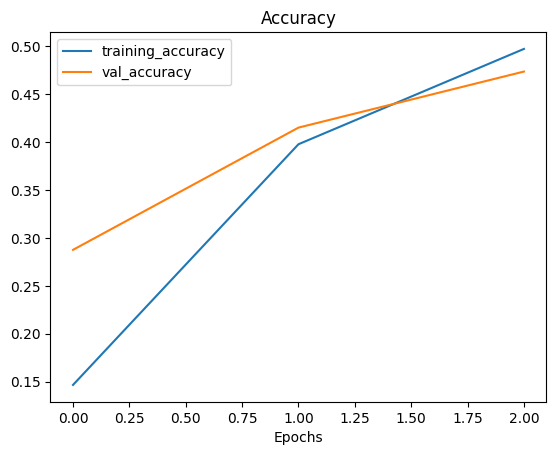

In [15]:
plot_loss_curves(history_10_percent)

## Fine tuning

In [16]:
# Unfreze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [17]:
# Recompile model with lower rate since we are fine tuning
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [18]:
# What layer in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [22]:
# Fine tune for 5 more epochs
fine_tune_epochs = 5 # Model has already 5 epochs (feature extration)

history_all_classes_10_percent_fine_tune = model.fit(
   train_data_all_10_percent,
    epochs=fine_tune_epochs,
   initial_epoch=history_10_percent.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # Valide only on 15 off test data
    callbacks=[checkpoint_callback]

)

Epoch 3/5
237/237 [==============================] - 64s 269ms/step - loss: 0.0276 - accuracy: 0.5773 - val_loss: 0.0298 - val_accuracy: 0.5079
Epoch 4/5
237/237 [==============================] - 64s 269ms/step - loss: 0.0252 - accuracy: 0.5995 - val_loss: 0.0285 - val_accuracy: 0.5236
Epoch 5/5
237/237 [==============================] - 53s 222ms/step - loss: 0.0236 - accuracy: 0.6255 - val_loss: 0.0278 - val_accuracy: 0.5336


In [23]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 62s 78ms/step - loss: 0.0248 - accuracy: 0.5870


[0.024769574403762817, 0.5870494842529297]

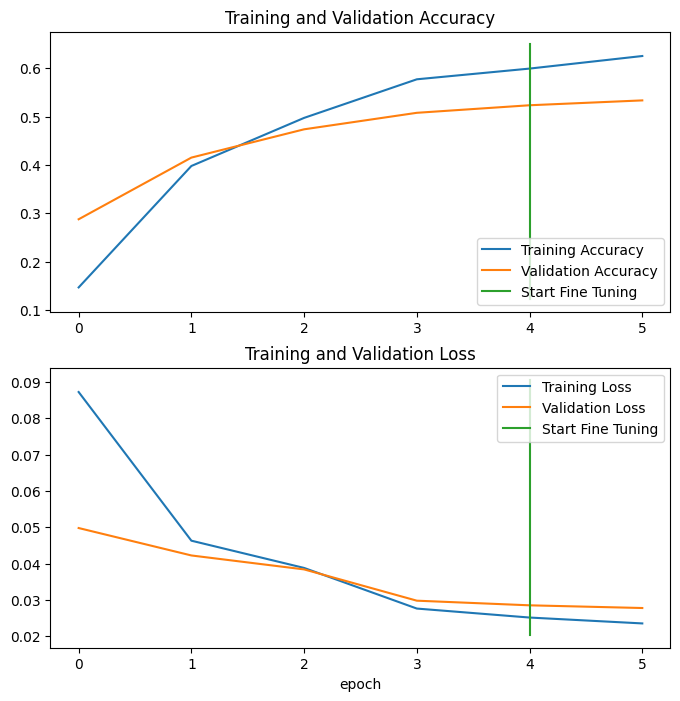

In [24]:
# Compare histories of feature extraction with fine tunning
compare_historys(history_10_percent, history_all_classes_10_percent_fine_tune, 5)

## Saving and loading model


In [25]:
# Save our fine tuning model

In [27]:
model.save("/content/drive/MyDrive/TF Models/01_f00d_classes_10_percent")

In [28]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TF Models/01_f00d_classes_10_percent")

In [29]:
# Evalaute loaded model and compare perfomance
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 62s 76ms/step - loss: 0.0248 - accuracy: 0.5870


[0.024769574403762817, 0.5870494842529297]

In [30]:
all_classes_10_percent_fine_tune_results

[0.024769574403762817, 0.5870494842529297]

In [32]:
loaded_model_results == all_classes_10_percent_fine_tune_results

True

## Evaluation the performance of the big model across all data

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path


In [34]:

# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 64s 79ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

## Making predictions with trained model

In [35]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 64s 79ms/step


In [37]:
# How many predictions are there?
len(preds_probs)

25250

In [38]:
preds_probs.shape

(25250, 101)

In [39]:
# Lets see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [41]:
preds_probs[0], sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

Our model outputs a prediction probability array

In [42]:
# We get one prediction per class
print(f"Number of prediction probs for sample 0: {len(preds_probs[0])}")
print(f"What predictions prob sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highes predicted prob by the model sample 0: {preds_probs[0].argmax()}")

Number of prediction probs for sample 0: 101
What predictions prob sample 0 looks like:
 [5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.0569885e-06 2.

In [43]:
test_data.class_names[52]

'gyoza'

In [45]:
pred_classes = preds_probs.argmax(axis=1)

# How they look
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [46]:
len(pred_classes)

25250